<a href="https://colab.research.google.com/github/ThatManRong/RL_Thesis/blob/main/Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [20]:
startdate="01/01/2015"
window_length = 50
encoding_dim = 15
epochs = 100
test_samples = 2000

In [22]:
def mkdate(ts):
    return datetime.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%m-%d')

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [23]:
start_timestamp = time.mktime(datetime.datetime.strptime(startdate, "%d/%m/%Y").timetuple())
end_timestamp = int(time.time())
one_week = 3600*24*7 # s
one_day = 3600*24 # s
weeks = list(np.arange(start_timestamp, end_timestamp, one_week))
days_recorded = (datetime.datetime.fromtimestamp(end_timestamp)-datetime.datetime.fromtimestamp(start_timestamp)).days
print("days_recorded ",days_recorded)
data = []
if not os.path.isfile("data.pickle"):
    s = req.Session()
    r = s.get("https://www.coindesk.com/price/")
    for i in range(1, len(weeks)):
        start_weekday = mkdate(weeks[i-1])
        end_weekday = mkdate(weeks[i]-one_day)
        print(start_weekday, end_weekday)
        r = s.get("https://api.coindesk.com/charts/data?data=close&startdate={}&enddate={}&exchanges=bpi&dev=1&index=USD".format(start_weekday, end_weekday))
        ans = json.loads(r.text.replace("cb(", "").replace(");",""))["bpi"]
        ans.sort(key=lambda x: x[0])
        for pricepoint in ans:
            if pricepoint[0]/1000 >= weeks[i-1] and pricepoint[0]/1000 < (weeks[i]-one_day):
                data.append([int(pricepoint[0]/1000), pricepoint[1]])
                
    pickle.dump(data, open("./data.pickle", "wb"))
else:
    data = pickle.load(open("./data.pickle", "rb"))

df = pd.DataFrame(np.array(data)[:,1], columns=['price'])
df['pct_change'] = df.price.pct_change()
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1)) #Get log returns

scaler = MinMaxScaler()
x_train_nonscaled = np.array([df['log_ret'].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df['log_ret'])))])
x_train = np.array([scaler.fit_transform(df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df['log_ret'])))])

x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

days_recorded  2178


100%|██████████| 41746/41746 [00:06<00:00, 6201.93it/s]


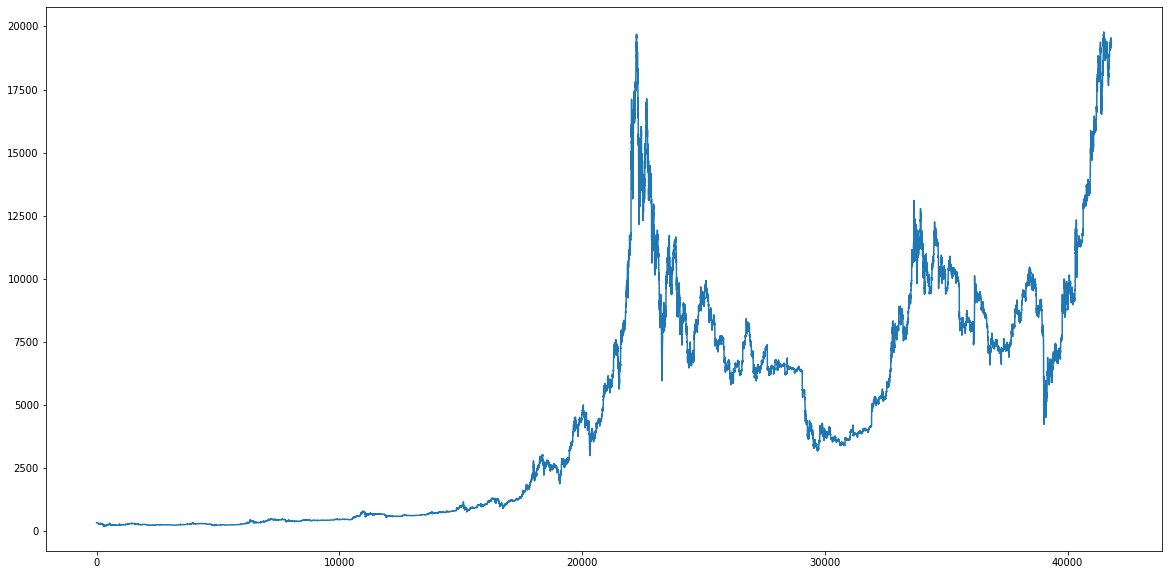

In [24]:
plt.figure(figsize=(20,10))
plt.plot(np.array(data)[:,1])

In [25]:
print("Percentage of test data: {}%".format((test_samples/len(x_train))*100))

Percentage of test data: 5.031952900920848%


#Simple MLP

In [26]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# this is our input placeholder
input_window = Input(shape=(window_length,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(window_length, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 15)                765       
_________________________________________________________________
dense_9 (Dense)              (None, 50)                800       
Total params: 1,565
Trainable params: 1,565
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
39/39 [==============================] - 1s 8ms/step - loss: 0.6967 - val_loss: 0.6920
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6911 - val_loss: 0.6882
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6863 - val_loss: 0.6819
Epoch 4/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6788 - val_los

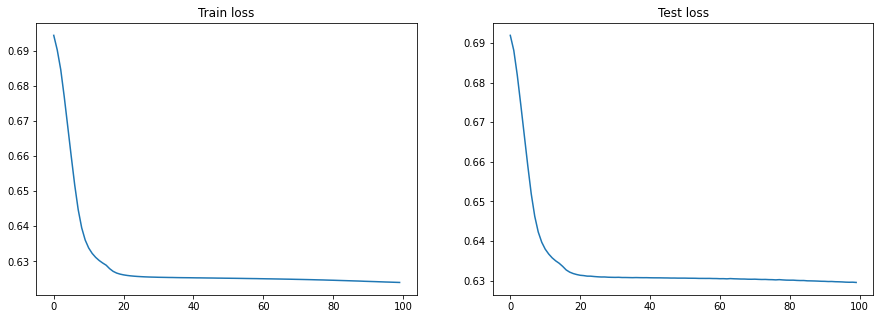

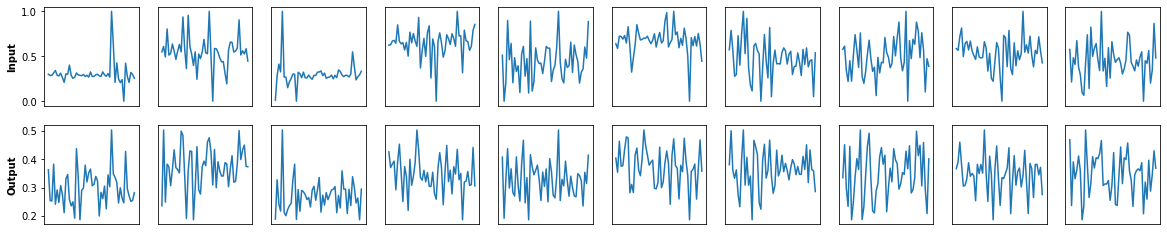

In [27]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)

#Deep Autoencoder

Fast Convergence, result looks okay

In [14]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 24        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                70  

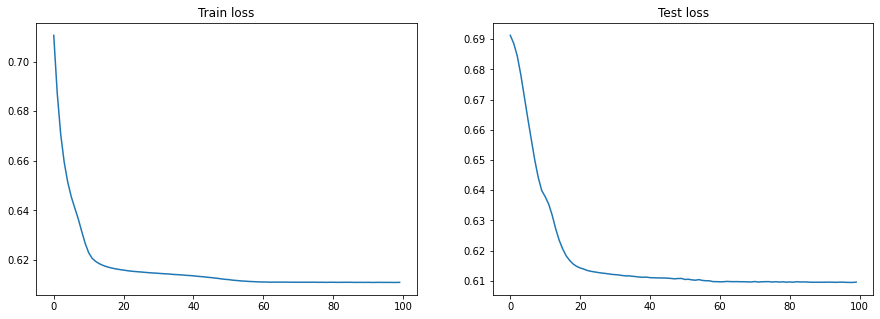

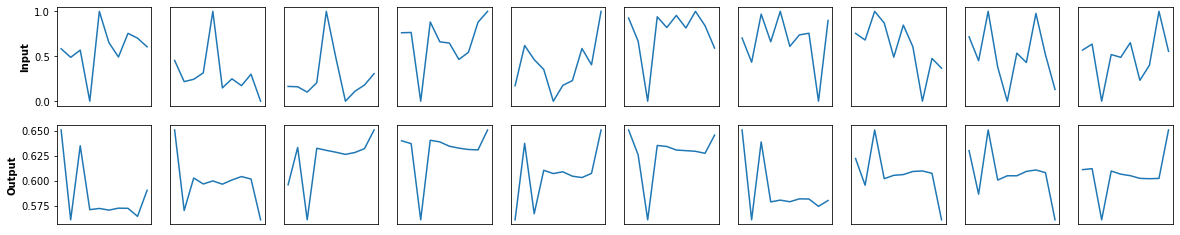

In [15]:
plot_history(history)
plot_examples(x_test_deep, decoded_stocks)


#CNN Autoencoder

Slow convergence, and bad result in general. 

In [16]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 6, 1)              0   

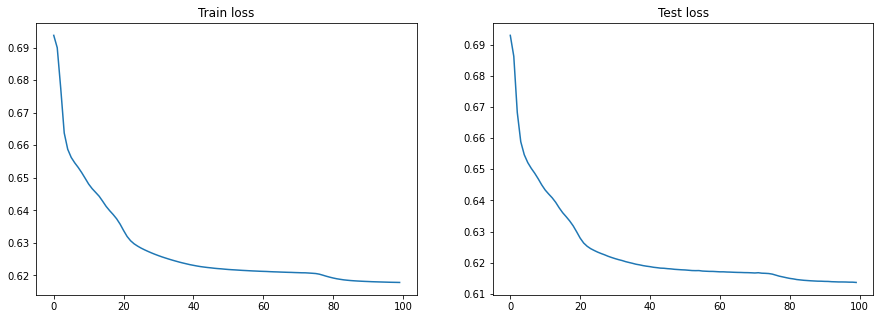

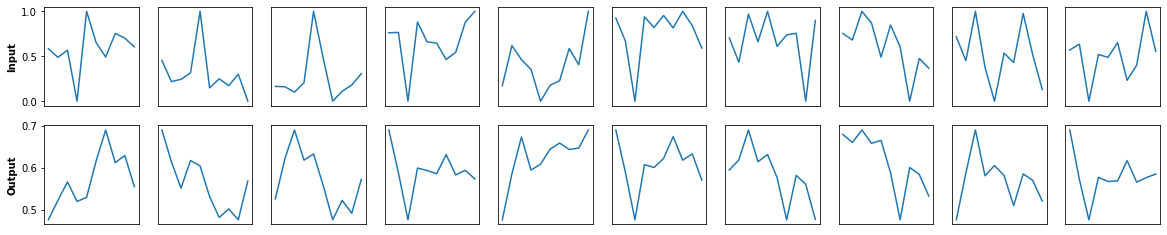

In [17]:
plot_history(history)
plot_examples(x_test_deep, decoded_stocks)


#LSTM Autoencoder

Maybe better dealing with sequential data? 

After testings: No, because of "lossy" compression. 
https://www.deeplearningbook.org/contents/rnn.html 

In [18]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
39/39 [==============================] - 5s 34ms/step - loss: 0.8785 - val_loss: 0.7707
Epoch 2/100
39/39 [==============================] - 1s 14ms/step - loss: 0.7694 - val_loss: 0.7362
Epoch 3/100
39/39 [==============================] - 1s 14ms/

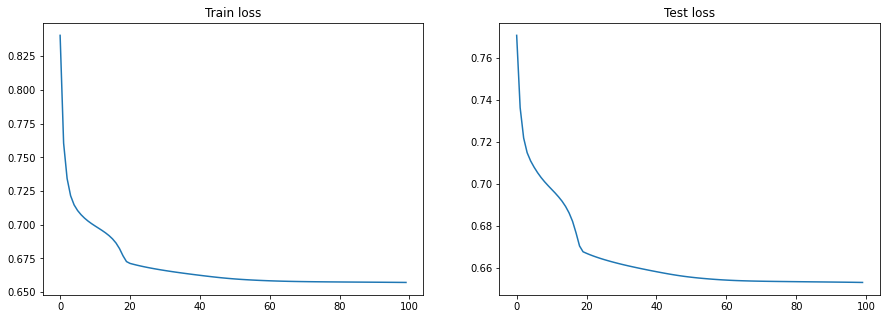

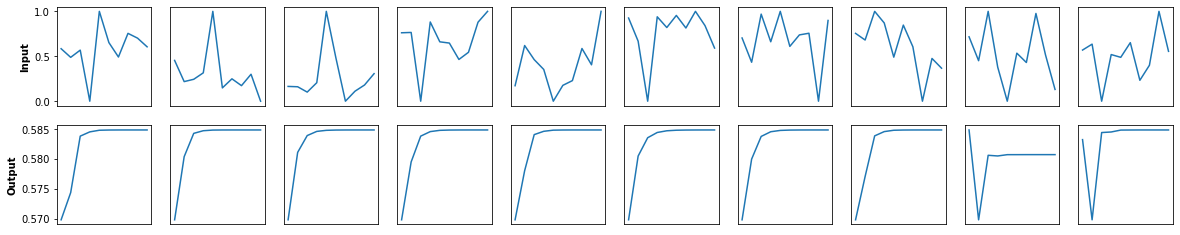

In [19]:
plot_history(history)
plot_examples(x_test_deep, decoded_stocks)
